# LASSO-BBN

Notes

- dm is response variable

Drop these variables
- Vlr 
- bs15
- TestTrain
- id

Algorithm

- dm ~ bs01lr + bs02lr + ... + bs19lr
- bs01lr ~ bs02lr + ... + bs19lr
- bs07lr ~ bs09lr + .... + bs11lr

What to do about missing values?

- use 1.0 since these are likelihood ratios
- use 0.0 because that might be the right thing to do; but scale data to [0, 1] range before regression
- imputation? 

TODO

- no need to do robust yet
- recursive LASSO
- induce BBN structure
- create parameters
- export graph to show mediations

In [1]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/BodySystemTrainTable.csv', low_memory=False)
raw_df.shape

(2063013, 23)

In [2]:
df = raw_df.drop(columns=['id', 'Vlr', 'bs15lr', 'TestTrain']) \
    .rename(columns={
        'bs1lr': 'bs01lr',
        'bs2lr': 'bs02lr',
        'bs3lr': 'bs03lr',
        'bs4lr': 'bs04lr',
        'bs5lr': 'bs05lr',
        'bs6lr': 'bs06lr',
        'bs7lr': 'bs07lr',
        'bs8lr': 'bs08lr',
        'bs9lr': 'bs09lr'
    })
df.shape

(2063013, 19)

In [38]:
df.isna().sum()

dm              0
bs01lr    1728725
bs02lr    1584907
bs03lr     781920
bs04lr    1798421
bs05lr     988523
bs06lr     899715
bs07lr     795886
bs08lr    1375571
bs09lr    1250320
bs10lr    1422029
bs11lr    2060940
bs12lr    1558015
bs13lr     854697
bs14lr    2013741
bs16lr     765461
bs17lr    1653390
bs18lr    1901535
bs19lr     118312
dtype: int64

In [39]:
df.iloc[0]

dm        1.000000
bs01lr         NaN
bs02lr         NaN
bs03lr    1.645058
bs04lr         NaN
bs05lr    1.195137
bs06lr         NaN
bs07lr    1.213059
bs08lr         NaN
bs09lr    1.960372
bs10lr         NaN
bs11lr         NaN
bs12lr         NaN
bs13lr         NaN
bs14lr         NaN
bs16lr    1.520102
bs17lr         NaN
bs18lr         NaN
bs19lr         NaN
Name: 0, dtype: float64

In [26]:
order_df = pd.read_csv('s3://jeeforce-artifacts/alemi/diabetes/ordering.csv') \
    .query('code != "rare_disease"')
order_df

,name,code,coefficient
0,Infectious_and_parasitic_diseases,bs01lr,0.000116
1,Diseases_of_the_circulatory_system,bs07lr,0.000112
2,"Endocrine,nutritional_and_metabolic diseases_a...",bs03lr,0.000112
3,Mental_disorders,bs05lr,0.000112
4,Diseases_of_the_digestive_system,bs09lr,0.000111
5,Diseases_of_the_respiratory_system,bs08lr,0.000110
6,Neoplasms,bs02lr,0.000110
7,Diseases_of_the_musculoskeletal_system_and_con...,bs13lr,0.000110
8,V_codes,bs19lr,0.000109
9,Diseases_of_the_nervous_system_and_sense_organs,bs06lr,0.000108


In [92]:
def get_order(code):
    r = order_df[order_df['code']==code].iloc[0]
    c = r['coefficient']
    codes = list(order_df[order_df['coefficient'] > c]['code'])
    return codes

order_map = {code: get_order(code) for code in order_df['code']}
order_map = {**order_map, **{'dm': list(order_df['code'])}}

In [176]:
order_map

{'bs01lr': [],
 'bs07lr': ['bs01lr'],
 'bs03lr': ['bs01lr', 'bs07lr'],
 'bs05lr': ['bs01lr', 'bs07lr', 'bs03lr'],
 'bs09lr': ['bs01lr', 'bs07lr', 'bs03lr', 'bs05lr'],
 'bs08lr': ['bs01lr', 'bs07lr', 'bs03lr', 'bs05lr', 'bs09lr'],
 'bs02lr': ['bs01lr', 'bs07lr', 'bs03lr', 'bs05lr', 'bs09lr', 'bs08lr'],
 'bs13lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr'],
 'bs19lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr',
  'bs13lr'],
 'bs06lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr',
  'bs13lr',
  'bs19lr'],
 'bs10lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr',
  'bs13lr',
  'bs19lr',
  'bs06lr'],
 'bs16lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr',
  'bs13lr',
  'bs19lr',
  'bs06lr',
  'bs10lr'],
 'bs12lr': ['bs01lr',
  'bs07lr',
  'bs03lr',
  'bs05lr',
  'bs09lr',
  'bs08lr',
  'bs02lr',
  'bs13l

In [192]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.special import expit
from sklearn.metrics import r2_score
import time

def mcfadden(estimator, X, y, method='normal'):
    def full_log_likelihood():
        score = estimator.predict_proba(X)[:,1]
        return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

    def null_log_likelihood():
        model = estimator.named_steps['regressor']
        score = np.array([model.intercept_[0] for _ in range(len(y))])
        return np.sum(-np.log(1 + np.exp(score))) + np.sum(y * score)

    def mcfadden_rsquare():
        return 1.0 - (full_log_likelihood() / null_log_likelihood())
    
    def mcfadden_adjusted_rsquare():
        k = float(X.shape[1])
        return 1.0 - ((full_log_likelihood() - k) / null_log_likelihood())
    
    if method == 'normal':
        return mcfadden_rsquare()
    else:
        return mcfadden_adjusted_rsquare()

def log_time(y_field, t0, t1):
    diff = t1 - t0
    diff = diff / 60
    print(f'\t{y_field} @ {diff:.1} minutes')
    
def get_coef(estimator, X):
    model = estimator.named_steps['regressor']
    
    return pd.Series(model.coef_[0], index=X.columns) \
        .to_frame(name='coefficient') \
        .reset_index() \
        .rename(columns={'index': 'field'}) \
        .assign(abs_coefficient=lambda d: np.abs(d['coefficient'])) \
        .sort_values(['abs_coefficient'], ascending=False) \
        .reset_index(drop=True)
    
def do_learn(df, y_field, C=0.001, tol=0.01):
    print(f'{y_field}')
    
    temp_df = df[df[y_field].notna()]
    # temp_df = temp_df.dropna()
    X = temp_df[[c for c in df.columns if c in order_map[y_field]]]
    y = temp_df[y_field]
        
    print(f'\t{X.shape}, {y.shape}')
    if X.shape[0] == 0 or X.shape[1] == 0:
        return np.nan
    
    t0 = time.time()
    
    if y_field == 'dm':
        model = LogisticRegression(
            random_state=37,
            penalty='l1', 
            C=C, 
            max_iter=5_000, 
            tol=tol, 
            n_jobs=-1, 
            solver='saga')
        print('\tmethod=LogLasso')
    else:
        model = Lasso(max_iter=5_000, random_state=37)
        # model = Ridge()
        # model = LinearRegression()
        print('\tmethod=RegLasso')
    
    # IterativeImputer(max_iter=100, random_state=37)
    estimator = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('regressor', model)
    ])
    estimator.fit(X, y)
    
    t1 = time.time()
    log_time(y_field, t0, t1)
    
    coef_df = get_coef(estimator, X)
    print(f'\tnon-zero coefficients: {(coef_df[coef_df["abs_coefficient"] > 0.01]).shape[0]}')
    
    if y_field == 'dm':
        r_sq = mcfadden(estimator, X, y)
        
    else:
        r_sq = r2_score(estimator.predict(X), y)
    
    print(f'\tr_sq={r_sq:.5f}')
    print('-' * 15)
    print(X.iloc[:10])
    print('-' * 15)
    print(y.iloc[:10])
    
    return coef_df

In [193]:
do_learn(df, 'bs04lr')

bs04lr
	(264592, 13), (264592,)
	method=RegLasso
	bs04lr @ 0.001 minutes
	non-zero coefficients: 0
	r_sq=0.00000
---------------
      bs01lr    bs02lr    bs03lr    bs05lr    bs06lr    bs07lr    bs08lr  \
13       NaN       NaN       NaN  1.195137  1.856803  1.954923  2.121893   
14  1.944497  1.137812  1.828600  1.113207  1.819179  1.759907       NaN   
30  1.206371       NaN  1.638189  0.642601  1.749600  1.992686  1.893996   
32  2.300992  2.031790  1.194173  1.177966  1.819179  1.759907  2.403264   
44  1.455551  1.250734  1.638189  2.468632  1.045209  2.286887  2.403264   
52  1.918044  1.549526       NaN  1.214827  0.891377  1.874905  2.118045   
57  1.723706  1.919393  2.621202  1.177966  0.309594  1.857712  1.412780   
87       NaN  1.547887       NaN       NaN  2.200093  1.378697       NaN   
91  1.651849       NaN  1.853287  1.177966  1.344532  3.261061  2.403264   
98       NaN       NaN  1.638189       NaN  2.032127  1.869658  1.893996   

      bs09lr    bs10lr    bs12lr  

,field,coefficient,abs_coefficient
0,bs01lr,0.0,0.0
1,bs02lr,0.0,0.0
2,bs03lr,0.0,0.0
3,bs05lr,0.0,0.0
4,bs06lr,0.0,0.0
5,bs07lr,0.0,0.0
6,bs08lr,0.0,0.0
7,bs09lr,0.0,0.0
8,bs10lr,0.0,0.0
9,bs12lr,0.0,0.0


In [175]:
# results = {y_field: do_learn(df, y_field) for y_field in sorted(list(order_map.keys()))}
do_learn(df, 'dm')

dm
	(2063013, 18), (2063013,)
	method=LogLasso
	dm @ 0.1 minutes
	non-zero coefficients: 10
	r_sq=0.53253, r_sq_adj=0.53253


,field,coefficient,abs_coefficient
0,bs03lr,3.300785,3.300785
1,bs17lr,2.153282,2.153282
2,bs06lr,1.861179,1.861179
3,bs05lr,1.848962,1.848962
4,bs13lr,1.719263,1.719263
5,bs09lr,1.493455,1.493455
6,bs02lr,1.473019,1.473019
7,bs08lr,1.276041,1.276041
8,bs12lr,1.179467,1.179467
9,bs01lr,0.829204,0.829204


In [132]:
def get_parents(key, zero_threshold=0.09):
    try:
        temp_df = results[key]
        temp_df = temp_df[temp_df['abs_coefficient'] > zero_threshold]
        return list(temp_df['field'])
    except:
        return []
    
parents = {ch: get_parents(ch) for ch in results}
parents

{'bs01lr': [],
 'bs02lr': [],
 'bs03lr': [],
 'bs04lr': [],
 'bs05lr': [],
 'bs06lr': [],
 'bs07lr': [],
 'bs08lr': [],
 'bs09lr': [],
 'bs10lr': [],
 'bs11lr': [],
 'bs12lr': [],
 'bs13lr': [],
 'bs14lr': [],
 'bs16lr': [],
 'bs17lr': [],
 'bs18lr': [],
 'bs19lr': [],
 'dm': ['bs11lr',
  'bs04lr',
  'bs03lr',
  'bs18lr',
  'bs06lr',
  'bs09lr',
  'bs05lr',
  'bs17lr',
  'bs08lr',
  'bs02lr',
  'bs07lr']}

In [133]:
import networkx as nx

g = nx.DiGraph()

for ch, pas in parents.items():
    for pa in pas:
        g.add_edge(pa, ch)

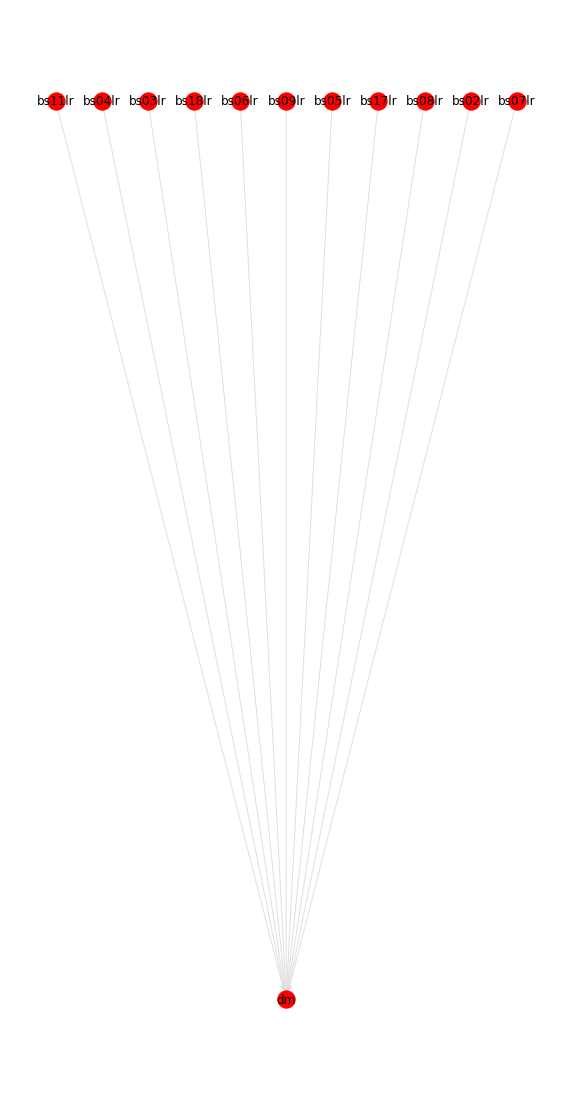

In [134]:
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

pos = graphviz_layout(g, prog='dot')

fig, ax = plt.subplots(figsize=(10, 20))
nx.draw(**{
        'G': g,
        'ax': ax,
        'pos': pos,
        'with_labels': True,
        'node_color': 'r',
        'edge_color': '#e0e0e0'
    })